# Lab: Decision Trees for Classification

## Learning Objectives
By the end of this lab, you will be able to:
- Understand how decision trees partition the feature space
- Visualise decision boundaries without requiring graphviz
- Explore the effect of key hyperparameters (max_depth, min_samples_split, min_samples_leaf)
- Compare decision trees with KNN and logistic regression
- Use cross-validation with different metrics (accuracy, F1, precision, recall)
- Understand when different evaluation metrics matter

Decision tree:
- Root (first question)
- Branches (splits)
- Leaves (final predictions)

## Setup

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)

## Part 1: Visualising Decision Boundaries

One of the key advantages of decision trees is their interpretability. While we can't use graphviz, we can visualize how decision trees partition the feature space by plotting decision boundaries.

### 1.1 Helper Function for Plotting Decision Boundaries

This function will help us visualize how different models divide the feature space.

In [21]:
def plot_decision_boundary(model, X, y, title="Decision Boundary", ax=None):
    """
    Plot the decision boundary of a classification model.
    
    Parameters:
    - model: fitted classifier
    - X: feature array (n_samples, 2)
    - y: labels
    - title: plot title
    - ax: matplotlib axis (optional)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a mesh to plot decision boundary
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    
    # Plot data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', 
                        edgecolors='black', s=50)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)
    plt.colorbar(scatter, ax=ax)
    
    return ax

### 1.2 Decision Trees on Make_Moons Dataset

Let's start with a non-linearly separable dataset to see how decision trees handle complex boundaries.

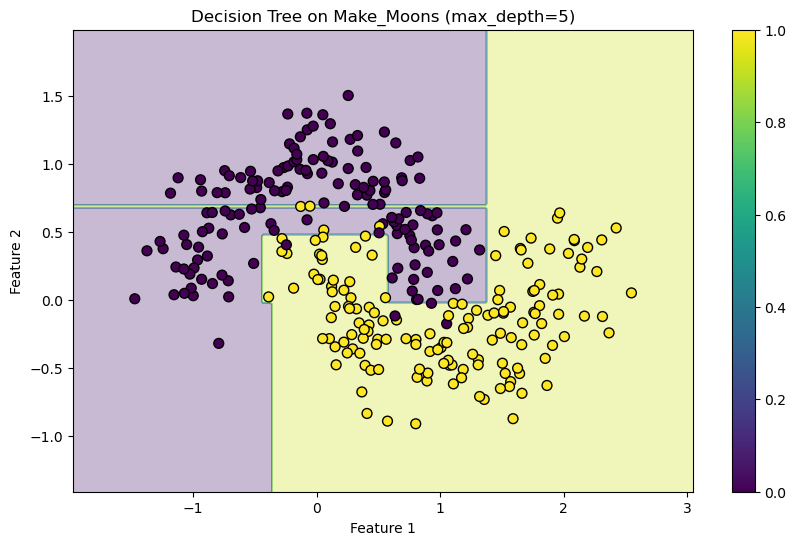

Training Accuracy: 0.983


In [22]:
# Generate make_moons dataset
X_moons, y_moons = make_moons(n_samples=300, noise=0.2, random_state=42)

# Train a decision tree
tree_moons = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_moons.fit(X_moons, y_moons)

# Visualize
plot_decision_boundary(tree_moons, X_moons, y_moons, 
                      title="Decision Tree on Make_Moons (max_depth=5)")
plt.show()

print(f"Training Accuracy: {tree_moons.score(X_moons, y_moons):.3f}")

**Question**: Notice how the decision boundary consists of rectangular regions. Why do you think this is?

---

### 1.3 Decision Trees on Make_Blobs with 4 Classes

Now let's try a multi-class problem to see how decision trees handle more complex classification tasks.

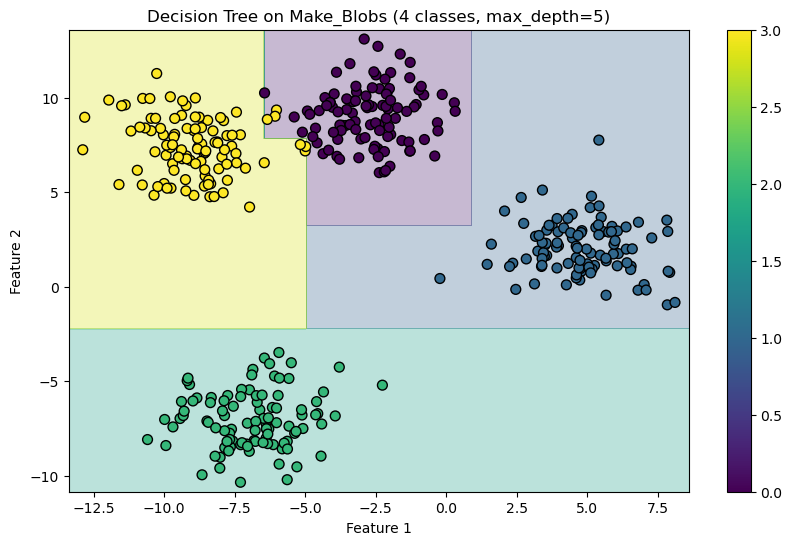

Training Accuracy: 0.993


In [23]:
# Generate make_blobs with 4 classes
X_blobs, y_blobs = make_blobs(n_samples=400, centers=4, n_features=2, 
                              cluster_std=1.5, random_state=42)

# Train a decision tree
tree_blobs = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_blobs.fit(X_blobs, y_blobs)

# Visualize
plot_decision_boundary(tree_blobs, X_blobs, y_blobs, 
                      title="Decision Tree on Make_Blobs (4 classes, max_depth=5)")
plt.show()

print(f"Training Accuracy: {tree_blobs.score(X_blobs, y_blobs):.3f}")

### 1.4 Exercise: Your Turn!

Create a decision tree for the make_moons dataset with `max_depth=2` and visualize the decision boundary. How does it compare to the tree with `max_depth=5`?

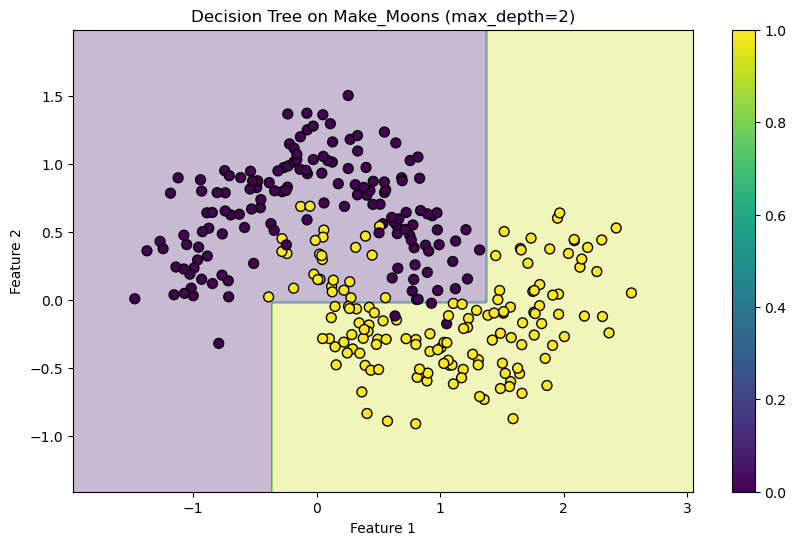

Training Accuracy: 0.903


In [24]:
# Train a shallow decision tree on make_moons
tree_shallow = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_shallow.fit(X_moons, y_moons)

# Visualize the decision boundary
plot_decision_boundary(tree_shallow, X_moons, y_moons,
                       title="Decision Tree on Make_Moons (max_depth=2)")
plt.show()

print(f"Training Accuracy: {tree_shallow.score(X_moons, y_moons):.3f}")

A shallow tree (depth 2) produces broad, simple boundaries, while a deeper tree (depth 5) produces highly detailed, wiggly boundaries that follow the data more closely.

max_depth - as the maximum number of questions the tree can ask before making a decision.
- Limits how many levels the tree can grow.
- Controls how complex the decision boundaries can become.

max_depth = 5
- Very flexible
- Can carve out complex shapes
- Fits the moons dataset almost perfectly
- Higher training accuracy
- But more prone to overfitting
  
max_depth = 2
- Much simpler model
- Only a few splits → large rectangular regions
- Cannot capture the curved moon shapes
- Lower training accuracy
- But more generalisable (less overfitting)


## Part 2: Understanding Decision Tree Hyperparameters

Decision trees have several important hyperparameters that control their complexity and prevent overfitting:

- **max_depth**: Maximum depth of the tree
- **min_samples_split**: Minimum samples required to split an internal node.(A node will only split if it has at least this many samples.)

    - If min_samples_split is too small:
        - Tree keeps splitting even on tiny groups
        - Leads to overfitting
        - Creates many tiny, noisy regions
    - If min_samples_split is too large:
        - Tree stops splitting early
        - Fewer, larger regions → underfitting

- **min_samples_leaf**: Minimum samples required at a leaf node (A leaf must contain at least this many samples. If a split would create a leaf with fewer samples → the split is not allowed.)

    - If min_samples_leaf is too small (e.g., 1):
        - Leaves can contain a single outlier
        - Tree memorizes noise → overfitting
    - If min_samples_leaf is too large:
        - Leaves become big and coarse
        - Decision boundaries become smoother → underfitting


### Summary of Key Decision Tree Hyperparameters

| Hyperparameter       | What it controls                     | If value is **too small** → | If value is **too large** → |
|----------------------|---------------------------------------|------------------------------|------------------------------|
| **`max_depth`**      | How many splits the tree can make     | Underfitting (too simple)    | Overfitting (too complex)    |
| **`min_samples_split`** | Minimum samples needed to split a node | Overfitting (splits tiny groups) | Underfitting (stops splitting early) |
| **`min_samples_leaf`**  | Minimum samples allowed in a leaf      | Overfitting (tiny, noisy leaves) | Underfitting (leaves too large, too smooth) |



### 2.1 Effect of max_depth

Let's see how varying `max_depth` affects the model's complexity and decision boundary.

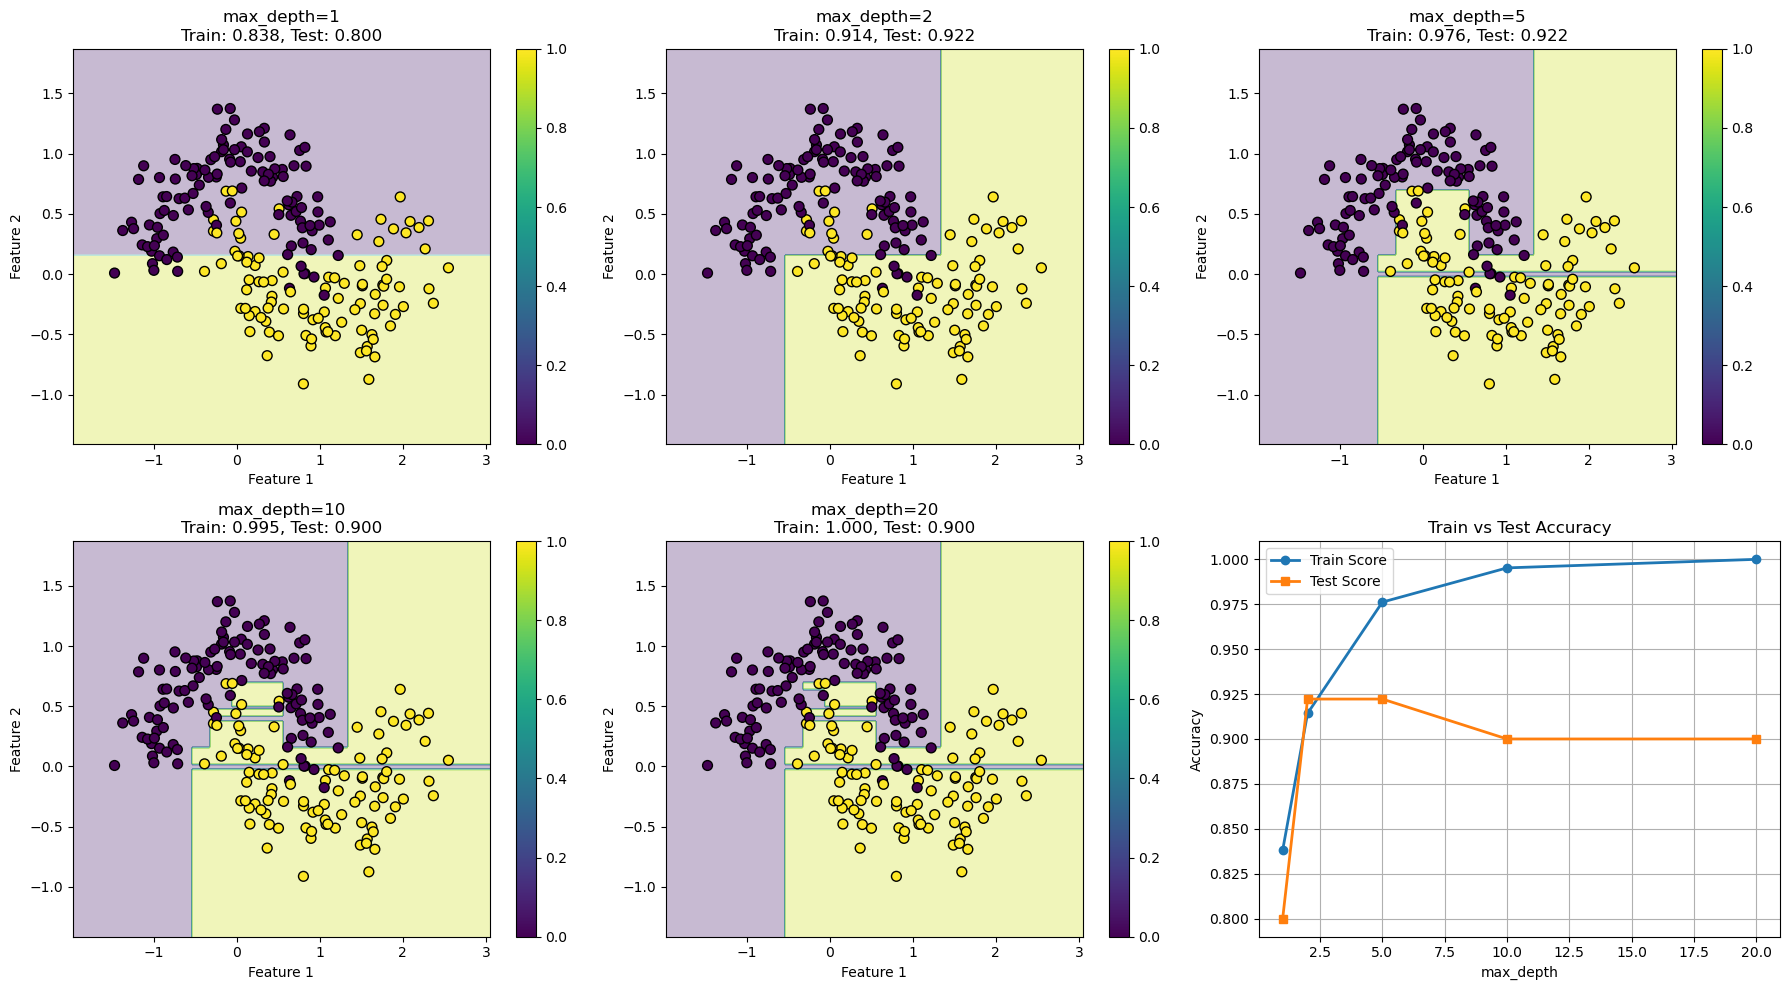

In [25]:
# Split data for proper evaluation
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, 
                                                    test_size=0.3, random_state=42)

# Try different max_depth values
depths = [1, 2, 5, 10, 20]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

train_scores = []
test_scores = []

for i, depth in enumerate(depths):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    
    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    plot_decision_boundary(tree, X_train, y_train, 
                          title=f"max_depth={depth}\nTrain: {train_score:.3f}, Test: {test_score:.3f}",
                          ax=axes[i])

# Plot train vs test scores
axes[-1].plot(depths, train_scores, marker='o', label='Train Score', linewidth=2)
axes[-1].plot(depths, test_scores, marker='s', label='Test Score', linewidth=2)
axes[-1].set_xlabel('max_depth')
axes[-1].set_ylabel('Accuracy')
axes[-1].set_title('Train vs Test Accuracy')
axes[-1].legend()
axes[-1].grid(True)

plt.tight_layout()
plt.show()

**Question**: At what depth does the model start to overfit? How can you tell?

Overfitting begins when the model fits the training data perfectly but performs worse on unseen test data — in your plots, that turning point is at max_depth ≈ 5.

Overfitting starts at max_depth = 5.

- At depth 5 → test accuracy is highest
- At depth 10 and 20 → training accuracy increases, but test accuracy decreases
- The decision boundaries become overly complex and noisy

---

### 2.2 Exercise: Exploring min_samples_split

The `min_samples_split` parameter controls how many samples are required to split an internal node. Higher values prevent the tree from learning very specific patterns.

Complete the code below to train trees with different `min_samples_split` values and compare their performance.

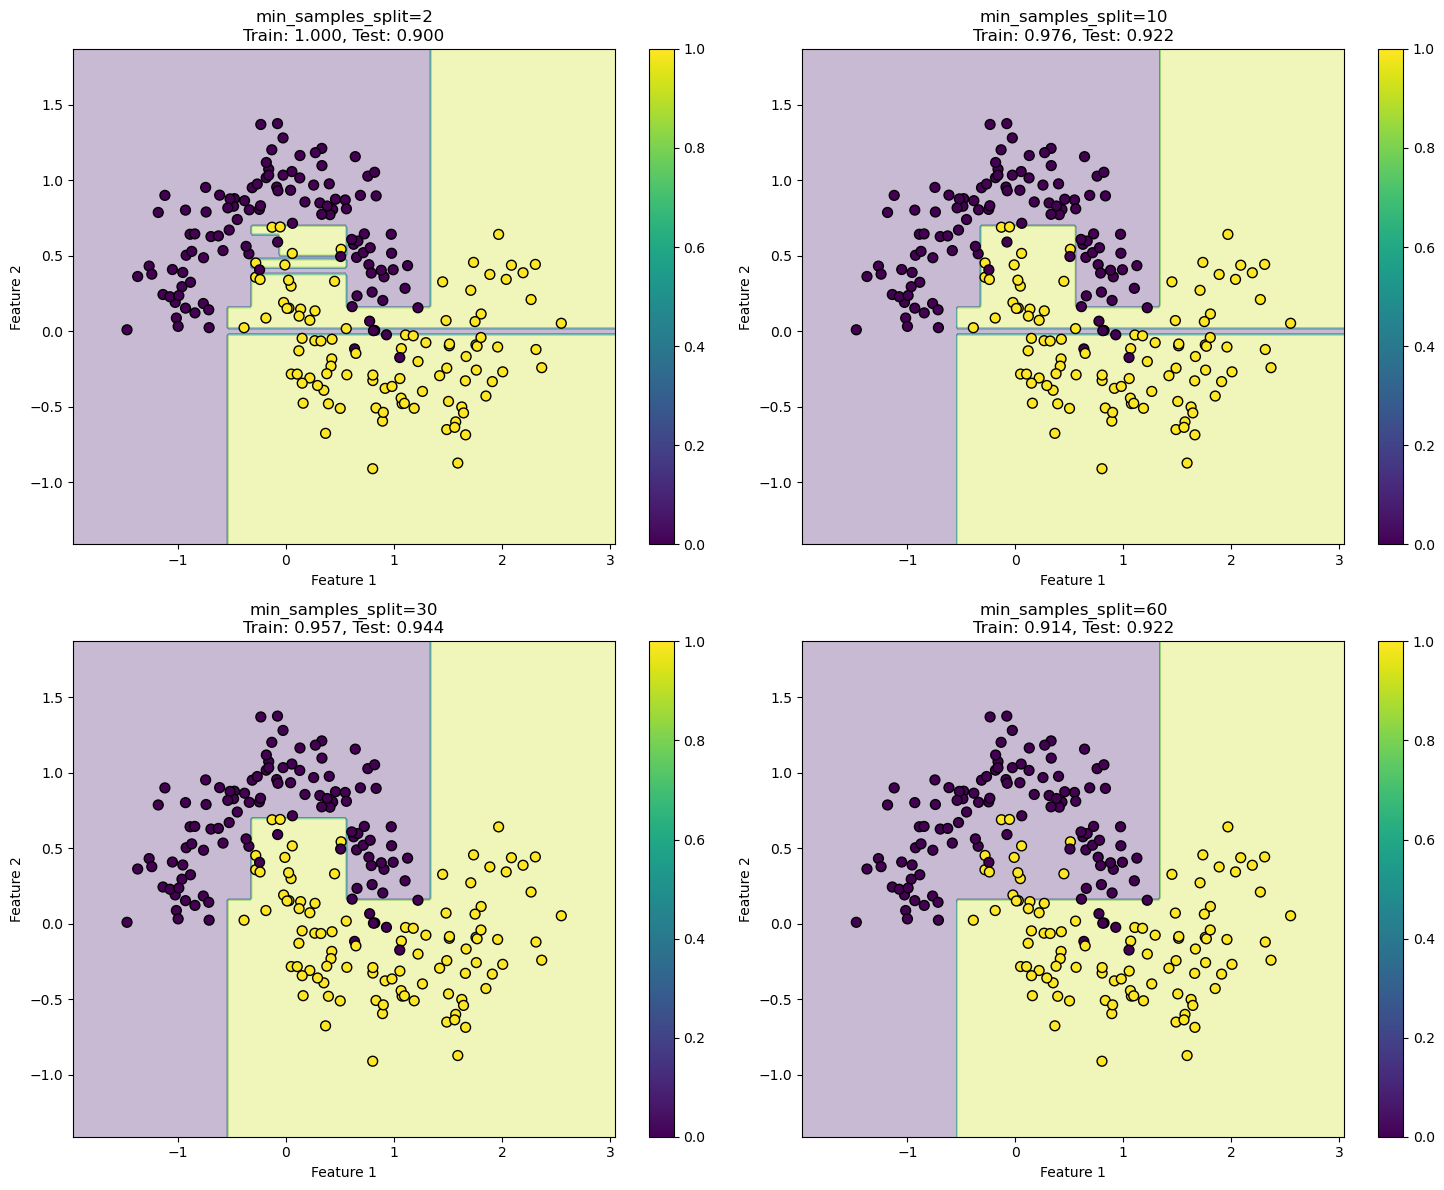

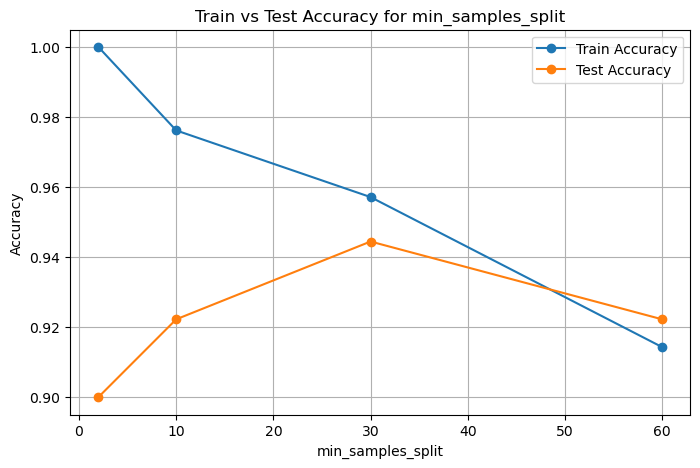

In [26]:
min_splits = [2, 10, 30, 60]   # you can adjust these values
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

train_scores = []
test_scores = []

for i, min_split in enumerate(min_splits):
    tree = DecisionTreeClassifier(min_samples_split=min_split, random_state=42)
    tree.fit(X_train, y_train)

    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

    plot_decision_boundary(
        tree, X_train, y_train,
        title=f"min_samples_split={min_split}\nTrain: {train_score:.3f}, Test: {test_score:.3f}",
        ax=axes[i]
    )

plt.tight_layout()
plt.show()

# -----------------------------
# Accuracy curve
# -----------------------------
plt.figure(figsize=(8,5))
plt.plot(min_splits, train_scores, marker='o', label='Train Accuracy')
plt.plot(min_splits, test_scores, marker='o', label='Test Accuracy')

plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy for min_samples_split")
plt.legend()
plt.grid(True)
plt.show()


### 2.3 Exercise: Exploring min_samples_leaf

Similarly, `min_samples_leaf` specifies the minimum number of samples required at each leaf node. This also helps prevent overfitting.

Train trees with `min_samples_leaf` values of [1, 5, 15, 30] and visualize the results.

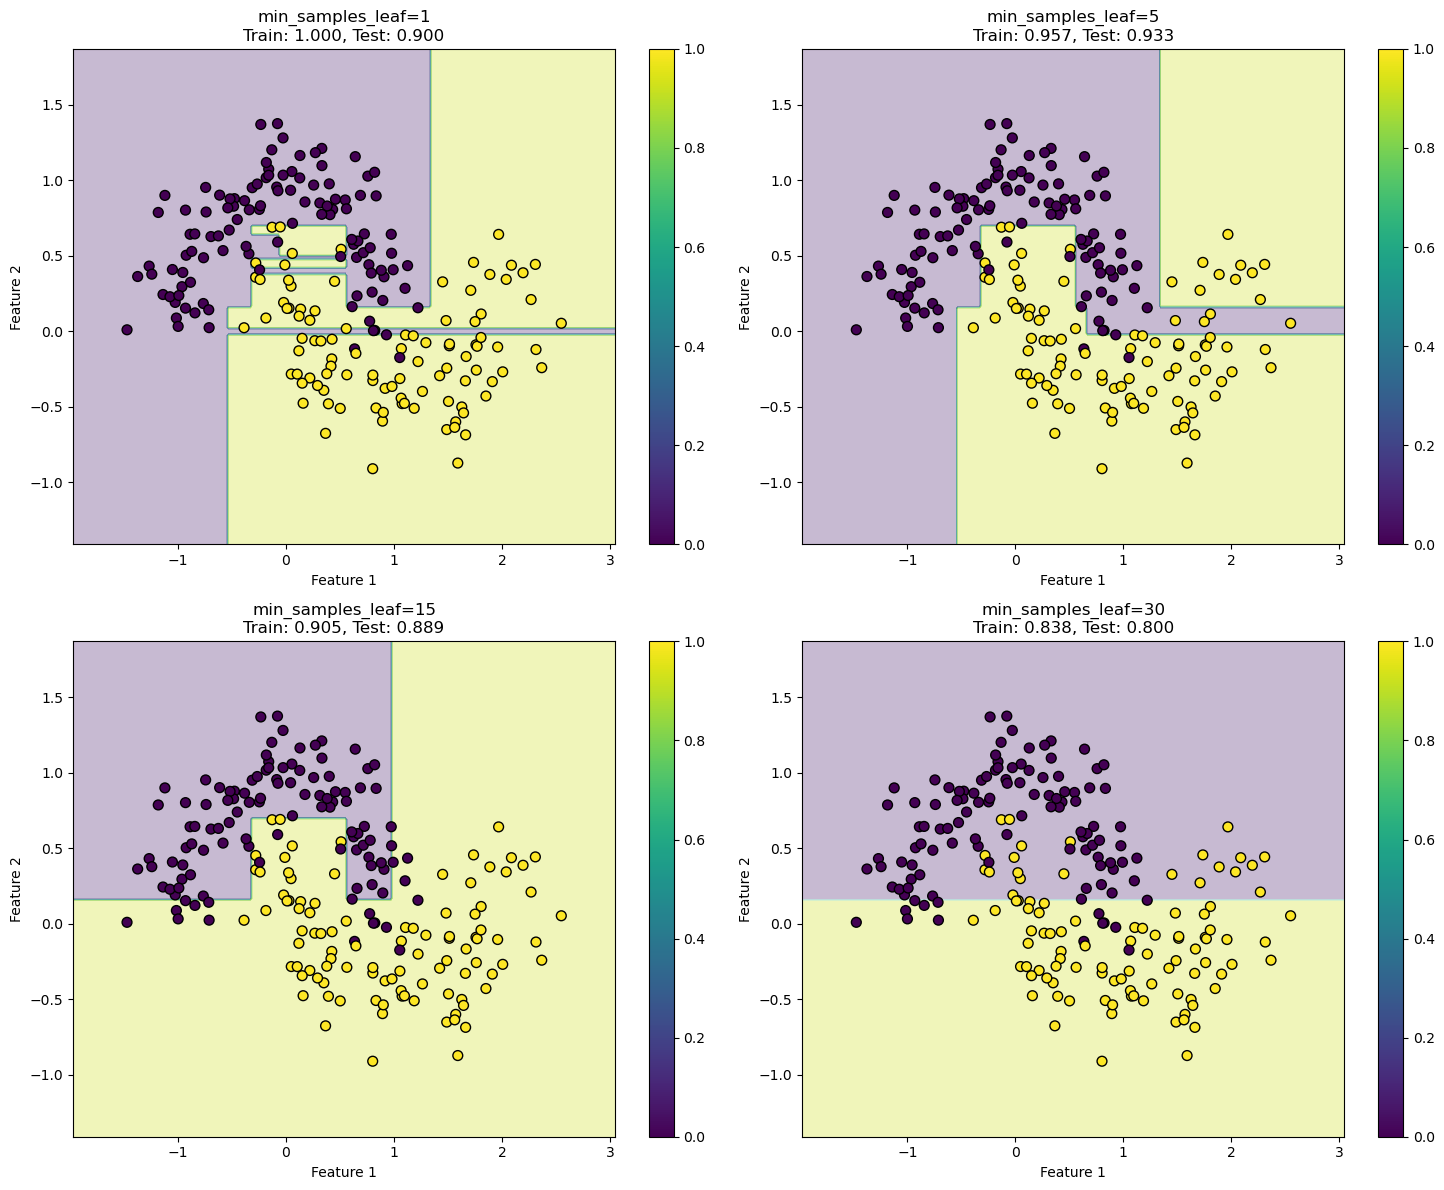

In [27]:
min_leafs = [1, 5, 15, 30]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, min_leaf in enumerate(min_leafs):
    tree = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=42)
    tree.fit(X_train, y_train)

    train_score = tree.score(X_train, y_train)
    test_score = tree.score(X_test, y_test)

    plot_decision_boundary(
        tree, X_train, y_train,
        title=f"min_samples_leaf={min_leaf}\nTrain: {train_score:.3f}, Test: {test_score:.3f}",
        ax=axes[i]
    )

plt.tight_layout()
plt.show()

## Part 3: Feature Importance (Alternative to Tree Visualization)

Since we can't use graphviz, another way to interpret decision trees is through feature importance. This tells us which features the tree relies on most for making decisions.

A decision tree makes predictions by splitting the data based on features.
- Some features get used a lot in these splits, others barely at all.
- Feature importance tells you how much each feature contributed to the tree’s decisions.
In the output:
- Feature 1 importance: 0.653
- Feature 2 importance: 0.347
This means:
- The tree relied on Feature 1 almost twice as much as Feature 2 when deciding how to split the data.
- Feature 1 contains more useful information for separating the classes in the blobs dataset.
- Feature 2 still matters, but less.

The bar chart is simply a visual version of these numbers.

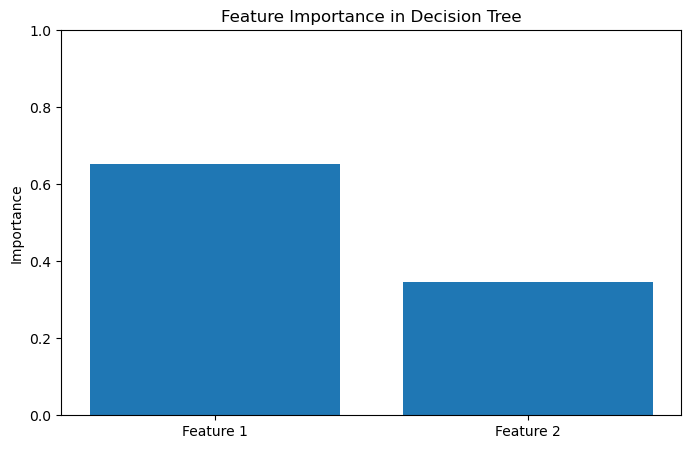

Feature 1 importance: 0.653
Feature 2 importance: 0.347


In [28]:
# Train a tree on the blobs dataset
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_blobs, y_blobs)

# Get feature importances
importances = tree.feature_importances_

# Plot
plt.figure(figsize=(8, 5))
plt.bar(['Feature 1', 'Feature 2'], importances)
plt.ylabel('Importance')
plt.title('Feature Importance in Decision Tree')
plt.ylim([0, 1])
plt.show()

print(f"Feature 1 importance: {importances[0]:.3f}")
print(f"Feature 2 importance: {importances[1]:.3f}")

## Part 3.1: Why Decision Trees Don't Need Feature Scaling

Unlike KNN and Logistic Regression, decision trees are **scale-invariant**. They only care about the relative ordering of values, not their magnitude. Let's demonstrate this!

In [29]:
# Create a dataset with features on very different scales
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Generate data where features have wildly different scales
np.random.seed(42)
X_unscaled = np.column_stack([
    np.random.normal(0, 1, 300),      # Feature 1: mean=0, std=1
    np.random.normal(0, 1000, 300)    # Feature 2: mean=0, std=1000 (1000x larger!)
])

# Create target based on both features
y_scale = ((X_unscaled[:, 0] > 0) & (X_unscaled[:, 1] > 0)).astype(int)

# Split the data
X_train_scale, X_test_scale, y_train_scale, y_test_scale = train_test_split(
    X_unscaled, y_scale, test_size=0.3, random_state=42
)

print("Feature scales (training set):")
print(f"  Feature 1 - Mean: {X_train_scale[:, 0].mean():.2f}, Std: {X_train_scale[:, 0].std():.2f}")
print(f"  Feature 2 - Mean: {X_train_scale[:, 1].mean():.2f}, Std: {X_train_scale[:, 1].std():.2f}")
print(f"\n  Feature 2 is ~1000x larger in scale!")

Feature scales (training set):
  Feature 1 - Mean: -0.04, Std: 1.03
  Feature 2 - Mean: 71.79, Std: 974.63

  Feature 2 is ~1000x larger in scale!


Now this code will scale the datamake a knn model, a logistic regression model and a decision tree model with the scaled data, and also models with the unscaled data

We should be able to see how scaling makes no difference to the Decision Tree while large differences to the others


Test Accuracy Comparison:
                          Accuracy
Decision Tree (Unscaled)     0.989
Decision Tree (Scaled)       0.989
KNN (Unscaled)               0.711
KNN (Scaled)                 0.956
Logistic Reg (Unscaled)      0.911
Logistic Reg (Scaled)        0.911


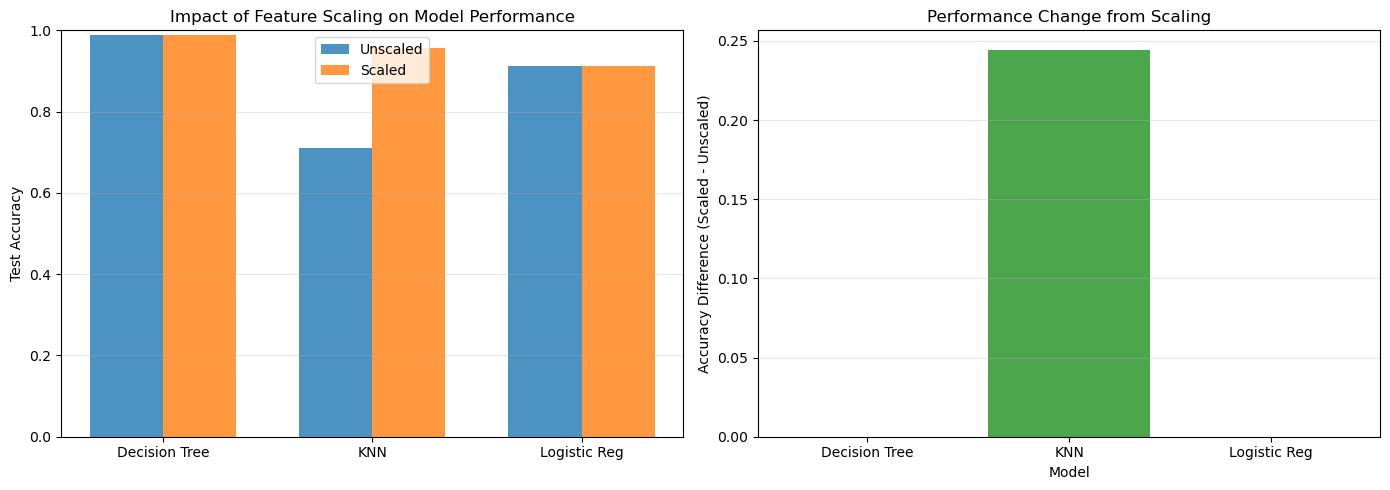


KEY INSIGHT:
Decision Tree: Scaling makes NO difference (same accuracy)
KNN & Logistic Regression: Scaling makes a HUGE difference!

Why? Decision trees only care about 'Is X > threshold?', not the
actual magnitude of X. KNN uses distances and LogReg uses magnitudes,
so they're sensitive to scale.


In [30]:
# Scale the data using StandardScaler
scaler = StandardScaler()  # Create a StandardScaler object to standardize features (mean=0, std=1)

X_train_scaled = scaler.fit_transform(X_train_scale)  # Fit scaler on TRAIN data and transform it (learn mean/std, then scale)
X_test_scaled = scaler.transform(X_test_scale)        # Transform TEST data using the SAME scaling learned from train data


# Train models on UNSCALED data
tree_unscaled = DecisionTreeClassifier(max_depth=5, random_state=42)  # Decision Tree (unscaled features)
knn_unscaled = KNeighborsClassifier(n_neighbors=5)                    # KNN with 5 neighbors (unscaled features)
logreg_unscaled = LogisticRegression(random_state=42)                 # Logistic Regression (unscaled features)

tree_unscaled.fit(X_train_scale, y_train_scale)   # Train Decision Tree on unscaled training data
knn_unscaled.fit(X_train_scale, y_train_scale)    # Train KNN on unscaled training data
logreg_unscaled.fit(X_train_scale, y_train_scale) # Train Logistic Regression on unscaled training data


# Train models on SCALED data
tree_scaled = DecisionTreeClassifier(max_depth=5, random_state=42)  # Decision Tree (scaled features)
knn_scaled = KNeighborsClassifier(n_neighbors=5)                    # KNN with 5 neighbors (scaled features)
logreg_scaled = LogisticRegression(random_state=42)                 # Logistic Regression (scaled features)

tree_scaled.fit(X_train_scaled, y_train_scale)   # Train Decision Tree on scaled training data
knn_scaled.fit(X_train_scaled, y_train_scale)    # Train KNN on scaled training data
logreg_scaled.fit(X_train_scaled, y_train_scale) # Train Logistic Regression on scaled training data


# Compare performance
results_scaling = pd.DataFrame({  # Create a DataFrame to store test accuracies for each model/version
    'Decision Tree (Unscaled)': [tree_unscaled.score(X_test_scale, y_test_scale)],   # DT accuracy on unscaled test data
    'Decision Tree (Scaled)': [tree_scaled.score(X_test_scaled, y_test_scale)],      # DT accuracy on scaled test data
    'KNN (Unscaled)': [knn_unscaled.score(X_test_scale, y_test_scale)],              # KNN accuracy on unscaled test data
    'KNN (Scaled)': [knn_scaled.score(X_test_scaled, y_test_scale)],                 # KNN accuracy on scaled test data
    'Logistic Reg (Unscaled)': [logreg_unscaled.score(X_test_scale, y_test_scale)],  # LogReg accuracy on unscaled test data
    'Logistic Reg (Scaled)': [logreg_scaled.score(X_test_scaled, y_test_scale)]      # LogReg accuracy on scaled test data
}, index=['Accuracy'])  # Use 'Accuracy' as the row index

print("\nTest Accuracy Comparison:")          # Print a header
print(results_scaling.T.round(3))            # Print the table, transposed (models as rows), rounded to 3 decimals


# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Create a figure with 2 subplots side by side


# Bar plot
models = ['Decision Tree', 'KNN', 'Logistic Reg']  # Names of the models for x-axis labels

unscaled_scores = [                                # Collect test accuracies for unscaled models
    tree_unscaled.score(X_test_scale, y_test_scale),
    knn_unscaled.score(X_test_scale, y_test_scale),
    logreg_unscaled.score(X_test_scale, y_test_scale)
]

scaled_scores = [                                  # Collect test accuracies for scaled models
    tree_scaled.score(X_test_scaled, y_test_scale),
    knn_scaled.score(X_test_scaled, y_test_scale),
    logreg_scaled.score(X_test_scaled, y_test_scale)
]

x = np.arange(len(models))  # Create positions for each model on the x-axis (0, 1, 2)
width = 0.35                # Width of each bar


axes[0].bar(x - width/2, unscaled_scores, width, label='Unscaled', alpha=0.8)  # Left bars: unscaled scores
axes[0].bar(x + width/2, scaled_scores, width, label='Scaled', alpha=0.8)      # Right bars: scaled scores

axes[0].set_ylabel('Test Accuracy')                             # y-axis label
axes[0].set_title('Impact of Feature Scaling on Model Performance')  # Plot title
axes[0].set_xticks(x)                                           # Set x-tick positions
axes[0].set_xticklabels(models)                                 # Set x-tick labels to model names
axes[0].legend()                                                # Show legend (Unscaled vs Scaled)
axes[0].set_ylim([0, 1])                                        # Fix y-axis range between 0 and 1
axes[0].grid(axis='y', alpha=0.3)                               # Add light horizontal grid lines


# Show the difference
differences = np.array(scaled_scores) - np.array(unscaled_scores)  # Compute (scaled - unscaled) accuracy for each model

colors = [  # Choose bar color based on whether scaling helped, hurt, or made little difference
    'green' if d > 0.01 else 'red' if d < -0.01 else 'gray'
    for d in differences
]

axes[1].bar(models, differences, color=colors, alpha=0.7)  # Bar plot of accuracy differences per model
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)  # Horizontal line at 0 (no change)
axes[1].set_ylabel('Accuracy Difference (Scaled - Unscaled)')      # y-axis label
axes[1].set_title('Performance Change from Scaling')               # Plot title
axes[1].set_xlabel('Model')                                        # x-axis label
axes[1].grid(axis='y', alpha=0.3)                                  # Add light horizontal grid lines

plt.tight_layout()  # Adjust layout so subplots and labels don’t overlap
plt.show()          # Display the plots


print("\n" + "="*70)                         # Print a separator line
print("KEY INSIGHT:")                        # Header for the summary
print("="*70)
print("Decision Tree: Scaling makes NO difference (same accuracy)")  # Summary for Decision Tree
print("KNN & Logistic Regression: Scaling makes a HUGE difference!") # Summary for KNN and Logistic Regression
print("\nWhy? Decision trees only care about 'Is X > threshold?', not the")
print("actual magnitude of X. KNN uses distances and LogReg uses magnitudes,")
print("so they're sensitive to scale.")                               # Explanation of *why* scaling matters differently


## Part 4: Comparing Classifiers on a Real Dataset

Now let's work with a real-world dataset where class imbalance makes the choice of evaluation metric crucial.

### 4.1 Loading the Credit Card Fraud Dataset

We'll use the famous Credit Card Fraud Detection dataset from Kaggle. This is a classic example where:
- Classes are **highly imbalanced** (only ~0.17% fraud!)
- **Accuracy can be misleading** (a model that always predicts "not fraud" would have >99.8% accuracy)
- **Precision and recall matter**: Missing fraud (low recall) costs money, but too many false alarms (low precision) wastes resources

#### How to get the dataset:
1. Download `creditcard.csv` from: https://www.kaggle.com/mlg-ulb/creditcardfraud or Moodle
2. Place it in the same directory as this notebook
3. Run the cell below (it will automatically fall back to simulated data if file not found)

This section introduces the Credit Card Fraud dataset, a real‑world dataset where:
- Fraud cases are extremely rare (only 0.17%)
- A model can get 99.8% accuracy by predicting “not fraud” every time
- So accuracy is useless
- Instead, we must use precision, recall, F1, etc.
  
The requirement is simply:
- Try to load the real dataset
- If it’s not available, generate a simulated one
- Show the class imbalance
- Split the data into train/test sets

In [31]:
# Try to load the real Kaggle dataset
try:
    print("Attempting to load Kaggle Credit Card Fraud dataset...")
    df = pd.read_csv('creditcard.csv') # Attempts to load the real fraud dataset from your folder.
    
    # Drop the Time column as it's not useful for classification
    df = df.drop('Time', axis=1)
    
    # Separate features and target
    X_fraud = df.drop('Class', axis=1).values
    y_fraud = df['Class'].values
    
    print(f"✓ Successfully loaded REAL dataset!")
    print(f"  Total transactions: {len(y_fraud):,}")
    print(f"  Features: {X_fraud.shape[1]}")
    
except FileNotFoundError:
    print("⚠ Kaggle dataset not found. Using simulated data instead.")
    print("  To use real data, download from: https://www.kaggle.com/mlg-ulb/creditcardfraud\n")
    
    from sklearn.datasets import make_classification
    
    # Create a realistic simulation with extreme imbalance
    X_fraud, y_fraud = make_classification(
        n_samples=10000,
        n_features=29,
        n_informative=20,
        n_redundant=5,
        n_classes=2,
        weights=[0.998, 0.002],  # 99.8% non-fraud, 0.2% fraud (similar to real data)
        flip_y=0.01,
        random_state=42
    )
    print(f"  Generated simulated dataset")

# Check class distribution
unique, counts = np.unique(y_fraud, return_counts=True)
print("\nClass distribution:")
for label, count in zip(unique, counts):
    fraud_label = "Non-Fraud" if label == 0 else "Fraud"
    print(f"  {fraud_label} (Class {label}): {count:,} ({count/len(y_fraud)*100:.2f}%)")

print(f"\n⚠ Imbalance ratio: {counts[0]/counts[1]:.1f}:1")
print(f"\nThis means a 'always predict non-fraud' model would get {counts[0]/len(y_fraud)*100:.2f}% accuracy!")

# Split the data
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud
)

print(f"\nTrain set: {len(X_train_fraud):,} samples")
print(f"Test set: {len(X_test_fraud):,} samples")

Attempting to load Kaggle Credit Card Fraud dataset...
✓ Successfully loaded REAL dataset!
  Total transactions: 284,807
  Features: 29

Class distribution:
  Non-Fraud (Class 0): 284,315 (99.83%)
  Fraud (Class 1): 492 (0.17%)

⚠ Imbalance ratio: 577.9:1

This means a 'always predict non-fraud' model would get 99.83% accuracy!

Train set: 199,364 samples
Test set: 85,443 samples


### 4.2 Baseline: Accuracy with Three Classifiers

Let's first compare Decision Trees, KNN, and Logistic Regression using simple accuracy.


Model Comparison:
                     Accuracy  Precision  Recall  F1-Score
Decision Tree           0.999      0.900   0.730     0.806
KNN                     0.999      0.916   0.662     0.769
Logistic Regression     0.999      0.860   0.622     0.722


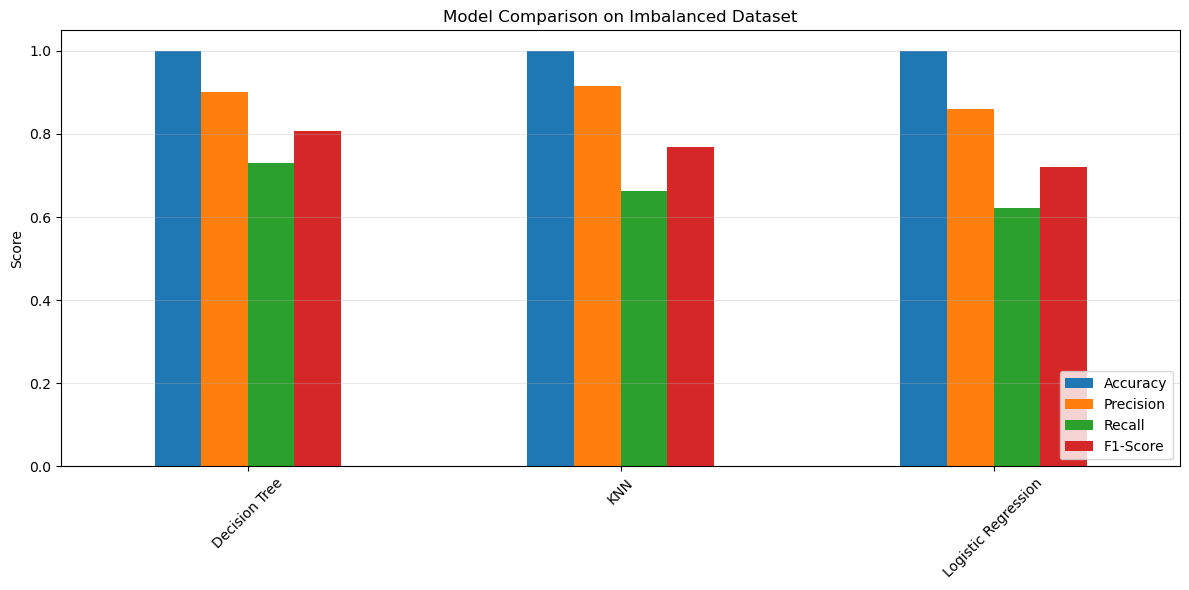

In [32]:
# Train three classifiers
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_fraud, y_train_fraud)
    y_pred = model.predict(X_test_fraud)
    
    accuracy = accuracy_score(y_test_fraud, y_pred)
    precision = precision_score(y_test_fraud, y_pred)
    recall = recall_score(y_test_fraud, y_pred)
    f1 = f1_score(y_test_fraud, y_pred)
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df.round(3))

# Visualize
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison on Imbalanced Dataset')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Question**: Which model has the highest accuracy? Does this mean it's the best model for fraud detection? Why or why not?


All three models have identical accuracy, but very different recall and F1. This is not a code bug — it’s exactly what happens on imbalanced datasets like credit card fraud.
Explore more:
- Accuracy
- Precision
- Recall
- F1‑Score

1. The dataset is extremely imbalanced. 99.8% non‑fraud. 0.2% fraud. (This is why accuracy is useless here.)
2. Look at the recall values: These numbers tell you how many fraud cases were actually caught. Accuracy doesn’t show this because fraud cases are so rare.
3. Precision, recall, and F1 are the real metrics that matter.

Ans: Decision Tree. 
- Best recall (catches most fraud): (0.730)
- Best precision (fewest false alarms): (0.900)
- Best F1 (balanced): (0.806)

---

### 4.3 Understanding the Metrics

Let's look at the confusion matrices to understand what's happening.

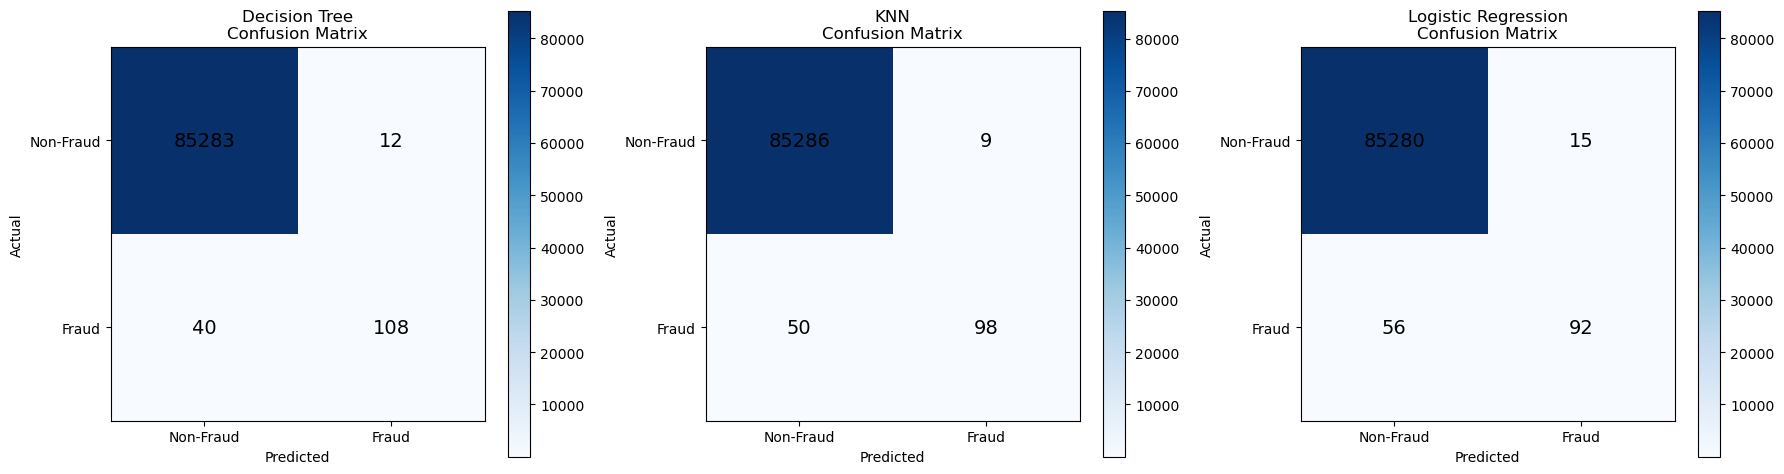

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_fraud)
    cm = confusion_matrix(y_test_fraud, y_pred)
    
    # Plot confusion matrix
    im = axes[i].imshow(cm, cmap='Blues')
    axes[i].set_title(f'{name}\nConfusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    axes[i].set_xticks([0, 1])
    axes[i].set_yticks([0, 1])
    axes[i].set_xticklabels(['Non-Fraud', 'Fraud'])
    axes[i].set_yticklabels(['Non-Fraud', 'Fraud'])
    
    # Add text annotations
    for j in range(2):
        for k in range(2):
            text = axes[i].text(k, j, cm[j, k],
                              ha="center", va="center", color="black", fontsize=14)
    
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

**Question**: Look at the bottom-right cell (actual fraud, predicted fraud). Which model catches the most fraud cases?

Ans: From the TP(Fraud) values: The Decision Tree catches the most fraud cases.  it tends to capture more minority‑class patterns, even in imbalanced datasets.

---

### 4.4 Exercise: Cross-Validation with Different Metrics

Now let's use cross-validation to get more robust performance estimates. We'll compare models using both accuracy and F1-score.

Complete the code below to perform 5-fold cross-validation with both metrics.

In [ ]:
# Your code here
# Perform 5-fold cross-validation for each model
# Calculate both accuracy and F1 scores
# Use StratifiedKFold to preserve class imbalance in each fold
from sklearn.model_selection import StratifiedKFold, cross_val_score
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}

for name, model in models.items():
    accuracy_scores = cross_val_score(model, X_fraud, y_fraud, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_fraud, y_fraud, cv=cv, scoring='f1')

    cv_results[name] = {
        'Accuracy (mean)': accuracy_scores.mean(),
        'Accuracy (std)': accuracy_scores.std(),
        'F1 (mean)': f1_scores.mean(),
        'F1 (std)': f1_scores.std()
    }

cv_df = pd.DataFrame(cv_results).T
print("\nCross-Validation Results (5-fold):")
print(cv_df.round(3))

### 4.5 Exercise: GridSearchCV for Hyperparameter Tuning

Let's use GridSearchCV to find the best hyperparameters for our Decision Tree, optimizing for F1-score instead of accuracy.

Complete the code below to tune the Decision Tree hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Define parameter grid for Decision Tree
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

tree_base = DecisionTreeClassifier(random_state=42)

# Use stratified folds (important for imbalanced fraud data)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV object (optimize for F1 of the positive class=1)
grid_search = GridSearchCV(
    estimator=tree_base,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_fraud, y_fraud)

# Print results
print("Best parameters found:")
print(grid_search.best_params_)
print(f"\nBest F1 score: {grid_search.best_score_:.3f}")

# Compare with default parameters (use the SAME cv object for a fair comparison)
default_tree = DecisionTreeClassifier(random_state=42)
default_f1 = cross_val_score(default_tree, X_fraud, y_fraud, cv=cv, scoring='f1', n_jobs=-1).mean()
print(f"Default tree F1 score: {default_f1:.3f}")
print(f"Improvement: {(grid_search.best_score_ - default_f1):.3f}")

### 4.6 Final Comparison: Tuned Models

Now let's compare our tuned Decision Tree with tuned versions of KNN and Logistic Regression, all optimized for F1-score.

In [ ]:
# Define parameter grids for all models
param_grids = {
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 10, 20],
        'min_samples_leaf': [1, 5, 10]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance']
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    }
}

base_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

tuned_models = {}
tuning_results = {}

for name in base_models.keys():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        base_models[name],
        param_grids[name],
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(X_train_fraud, y_train_fraud)
    
    tuned_models[name] = grid_search.best_estimator_
    
    # Test on held-out test set
    y_pred = grid_search.best_estimator_.predict(X_test_fraud)
    
    tuning_results[name] = {
        'Best Params': grid_search.best_params_,
        'CV F1 Score': grid_search.best_score_,
        'Test Accuracy': accuracy_score(y_test_fraud, y_pred),
        'Test Precision': precision_score(y_test_fraud, y_pred),
        'Test Recall': recall_score(y_test_fraud, y_pred),
        'Test F1': f1_score(y_test_fraud, y_pred)
    }
    
    print(f"  Best params: {grid_search.best_params_}")
    print(f"  CV F1: {grid_search.best_score_:.3f}")
    print(f"  Test F1: {f1_score(y_test_fraud, y_pred):.3f}")

# Create summary DataFrame (excluding best params for display)
summary_data = {name: {k: v for k, v in results.items() if k != 'Best Params'} 
                for name, results in tuning_results.items()}
summary_df = pd.DataFrame(summary_data).T

print("\n" + "="*70)
print("FINAL RESULTS: Tuned Models on Test Set")
print("="*70)
print(summary_df.round(3))

# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot metrics comparison
summary_df[['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1']].plot(
    kind='bar', ax=axes[0]
)
axes[0].set_title('Tuned Models: Test Set Performance')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

# Plot CV vs Test F1
x = np.arange(len(tuned_models))
width = 0.35
axes[1].bar(x - width/2, summary_df['CV F1 Score'], width, label='CV F1', alpha=0.8)
axes[1].bar(x + width/2, summary_df['Test F1'], width, label='Test F1', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Cross-Validation vs Test F1 Scores')
axes[1].set_xticks(x)
axes[1].set_xticklabels(tuned_models.keys(), rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 4.7 Exercise: Comparing Accuracy vs F1 Optimization

Let's see what happens when we optimize for accuracy instead of F1-score. Complete the code below to tune a Decision Tree using accuracy as the metric.

In [ ]:
# Your code here
# Tune a Decision Tree using accuracy instead of F1

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Create GridSearchCV with scoring='accuracy'


# Fit and evaluate


# Compare with F1-optimized tree
y_pred_acc = grid_search_acc.predict(X_test_fraud)
y_pred_f1 = tuned_models['Decision Tree'].predict(X_test_fraud)

comparison = pd.DataFrame({
    'Optimized for Accuracy': {
        'Test Accuracy': accuracy_score(y_test_fraud, y_pred_acc),
        'Test Precision': precision_score(y_test_fraud, y_pred_acc),
        'Test Recall': recall_score(y_test_fraud, y_pred_acc),
        'Test F1': f1_score(y_test_fraud, y_pred_acc)
    },
    'Optimized for F1': {
        'Test Accuracy': accuracy_score(y_test_fraud, y_pred_f1),
        'Test Precision': precision_score(y_test_fraud, y_pred_f1),
        'Test Recall': recall_score(y_test_fraud, y_pred_f1),
        'Test F1': f1_score(y_test_fraud, y_pred_f1)
    }
})

print("\nComparison: Accuracy vs F1 Optimization")
print(comparison.T.round(3))

**Question**: Why does optimizing for F1 produce different results than optimizing for accuracy? Which optimization strategy would you choose for fraud detection and why?

---

## Part 5: Summary and Reflection

### Key Takeaways:

1. **Decision Tree Interpretability**: Decision trees create rectangular decision boundaries by making axis-parallel splits. We can visualize these boundaries and understand feature importance even without tree diagrams.

2. **Hyperparameter Effects**:
   - `max_depth` controls model complexity and overfitting
   - `min_samples_split` and `min_samples_leaf` provide additional regularization
   - Proper tuning is essential for good generalization

3. **Metric Selection Matters**:
   - Accuracy can be misleading on imbalanced datasets
   - F1-score balances precision and recall
   - The right metric depends on the cost of false positives vs false negatives

4. **Model Comparison**:
   - Decision Trees, KNN, and Logistic Regression each have strengths
   - Cross-validation provides robust performance estimates
   - GridSearchCV helps find optimal hyperparameters

### Reflection Questions:

1. When would you prefer a Decision Tree over KNN or Logistic Regression?
2. How do you decide which evaluation metric to use for a given problem?
3. What are the trade-offs between model complexity and interpretability?

---

## Bonus Challenge (Optional)

Try the following extensions:

1. **Experiment with class weights**: Decision trees support a `class_weight='balanced'` parameter. How does this affect performance on imbalanced data?

2. **Feature engineering**: Create new features from the fraud dataset and see if they improve model performance.

3. **Ensemble methods**: Research and try `RandomForestClassifier` - how does it compare to a single decision tree?

In [ ]:
# Your bonus code here
